In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, sys
%cd "/content/drive/MyDrive/CSCI181V - Final Project"

# add the current directory to the Python module search path
sys.path.append(os.getcwd())


/content/drive/MyDrive/CSCI181V - Final Project


In [ ]:
!pip install gymnasium torch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 12.6 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
from gymnasium.envs.registration import register

register(
    id="Snake-10x10-v0",                 # ASCII hyphens
    entry_point="Snake:SnakeEnv",        # file Snake.py (module) : class
    max_episode_steps=400,
)



In [ ]:
env = gym.make("Snake-10x10-v0")


In [ ]:
import random
import numpy as np
from collections import deque
from typing import Deque, Tuple

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

"""
DQN training script for the **Snake** 10 × 10 environment.

### Colab setup (Option B – register in notebook)
```python
from google.colab import drive
import os, sys, gymnasium as gym
from gymnasium.envs.registration import register

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CSCI181V - Final Project')
sys.path.append(os.getcwd())

import Snake  # Snake.py defines class SnakeEnv
register(
    id="Snake-10x10-v0",
    entry_point="Snake:SnakeEnv",
    max_episode_steps=400,
)
```
Then run:
```python
import dqn_snake; dqn_snake.main()
```

### Key hyper‑params
* 5 000 episodes
* ε‑greedy **exponential decay**: ε = max(0.05, 1.0 × 0.995^episode)
* Target network sync every 1 000 env steps
"""

# ---------------------------------------------------------------------------
# Observation wrapper
# ---------------------------------------------------------------------------

class OneHotObsWrapper(gym.ObservationWrapper):
    """Convert 10 × 10 int grid → (4, 10, 10) one‑hot float tensor."""

    def __init__(self, env: gym.Env):
        super().__init__(env)
        h, w = env.observation_space.shape
        self.observation_space = gym.spaces.Box(0.0, 1.0, shape=(4, h, w), dtype=np.float32)

    def observation(self, obs):
        one_hot = np.zeros((4, *obs.shape), dtype=np.float32)
        for v in range(4):
            one_hot[v][obs == v] = 1.0
        return one_hot


# ---------------------------------------------------------------------------
# DQN network
# ---------------------------------------------------------------------------

class ConvDQN(nn.Module):
    def __init__(self, input_channels: int = 4, n_actions: int = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 10 * 10, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------------------------------------------------------
# Replay buffer
# ---------------------------------------------------------------------------

class ReplayBuffer:
    def __init__(self, capacity: int = 50_000):
        self.buffer: Deque[Tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------

@torch.no_grad()
def select_action(net, state, epsilon, action_space):
    if random.random() < epsilon:
        return action_space.sample()
    q_values = net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    return int(torch.argmax(q_values))


def compute_td_loss(batch, online_net, target_net, gamma):
    states, actions, rewards, next_states, dones = batch
    q_values = online_net(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_net(next_states)
        next_q_value = next_q_values.max(1)[0]
        target = rewards + gamma * next_q_value * (1.0 - dones)

    return nn.functional.mse_loss(q_value, target)


# ---------------------------------------------------------------------------
# Training loop
# ---------------------------------------------------------------------------

def main():
    if "Snake-10x10-v0" not in gym.registry:
        raise RuntimeError("'Snake-10x10-v0' not registered – run the notebook cell first.")

    env = OneHotObsWrapper(gym.make("Snake-10x10-v0"))

    # RNG seeds
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Networks & optimizer
    online_net = ConvDQN()
    target_net = ConvDQN()
    target_net.load_state_dict(online_net.state_dict())
    optimizer = optim.Adam(online_net.parameters(), lr=1e-3)

    buffer = ReplayBuffer(50_000)

    # Hyper‑parameters
    num_episodes = 1_000
    gamma = 0.99
    batch_size = 64
    min_buffer_size = 5_000
    target_update_steps = 1_000

    # ε exponential decay
    epsilon_start, epsilon_final = 1.0, 0.1
    epsilon_decay_rate = 0.9975

    global_step = 0

    reward_history = []

    for ep in range(1, num_episodes + 1):
        epsilon = max(epsilon_final, epsilon_start * (epsilon_decay_rate ** ep))
        state, _ = env.reset()
        ep_reward = 0.0
        done = truncated = False

        while not (done or truncated):
            action = select_action(online_net, state, epsilon, env.action_space)
            next_state, reward, done, truncated, _ = env.step(action)
            terminal = done or truncated

            buffer.push(state, action, reward, next_state, terminal)
            state = next_state
            ep_reward += reward
            global_step += 1

            # Learn
            if len(buffer) >= min_buffer_size:
                batch = buffer.sample(batch_size)
                loss = compute_td_loss(batch, online_net, target_net, gamma)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Target network sync
            if global_step % target_update_steps == 0:
                target_net.load_state_dict(online_net.state_dict())

        print(f"Episode {ep:4d} | Reward {ep_reward:6.1f} | ε {epsilon:.3f}")

        reward_history.append(ep_reward)

    env.close()
    return online_net, reward_history



if __name__ == "__main__":
    online_net, reward_history = main()

Episode    1 | Reward  -11.0 | ε 0.998
Episode    2 | Reward  -11.2 | ε 0.995
Episode    3 | Reward   -0.9 | ε 0.993
Episode    4 | Reward  -11.0 | ε 0.990
Episode    5 | Reward  -10.9 | ε 0.988
Episode    6 | Reward  -10.9 | ε 0.985
Episode    7 | Reward  -11.0 | ε 0.983
Episode    8 | Reward  -11.1 | ε 0.980
Episode    9 | Reward   -0.9 | ε 0.978
Episode   10 | Reward  -11.1 | ε 0.975
Episode   11 | Reward  -11.0 | ε 0.973
Episode   12 | Reward  -11.1 | ε 0.970
Episode   13 | Reward  -11.0 | ε 0.968
Episode   14 | Reward  -10.9 | ε 0.966
Episode   15 | Reward  -10.9 | ε 0.963
Episode   16 | Reward  -10.9 | ε 0.961
Episode   17 | Reward  -10.8 | ε 0.958
Episode   18 | Reward  -11.0 | ε 0.956
Episode   19 | Reward  -11.0 | ε 0.954
Episode   20 | Reward  -10.9 | ε 0.951
Episode   21 | Reward  -11.0 | ε 0.949
Episode   22 | Reward  -11.0 | ε 0.946
Episode   23 | Reward  -10.8 | ε 0.944
Episode   24 | Reward  -10.9 | ε 0.942
Episode   25 | Reward  -11.1 | ε 0.939
Episode   26 | Reward  -1

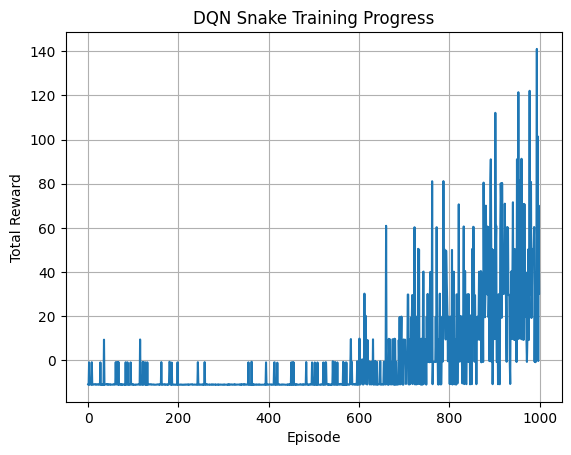

In [ ]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Snake Training Progress")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
# --- Plot rewards ---
plt.figure(figsize=(8,5))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Mini Training Rewards')
plt.grid(True)
plt.show()


NameError: name 'reward_history' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
from IPython.display import clear_output
import time

# --- Greedy episode visualization ---
env = OneHotObsWrapper(gym.make("Snake-10x10-v0"))
state, _ = env.reset()
done = False
truncated = False
total_reward = 0

while not (done or truncated):
    clear_output(wait=True)
    env.render()
    time.sleep(0.2)

    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = online_net(state_tensor)
        action = torch.argmax(q_values, dim=1).item()

    state, reward, done, truncated, _ = env.step(action)
    total_reward += reward

# Final frame
clear_output(wait=True)
env.render()
print(f"\nTotal reward from greedy episode: {total_reward}")
env.close()

..........
..........
..........
....==𓆗...
....======
....==...=
.........=
.....F...=
..........
..........


Total reward from greedy episode: 112.33000000000048
